# Understanding Text Embeddings

In [1]:
!pip install -q --upgrade transformers diffusers ftfy

In [2]:
from huggingface_hub import notebook_login
from pathlib import Path
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [5]:
prompt = ["a picture of an indian women by greg rutkowski"]
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [6]:
def gen_with_text_embeddings(text_embeddings, height=512, width=512, steps=50, gd=7.5, seed=2324, resize_factor=0.5):
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    # Prep text 
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(steps)

    # Prep latents
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + gd * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    im = pil_images[0]
    return im.resize(((int)(im.width * resize_factor), (int)(im.height * resize_factor)))

0it [00:00, ?it/s]

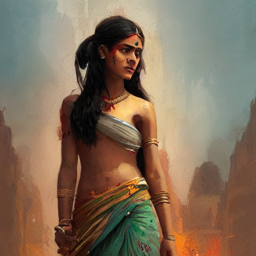

In [7]:
gen_with_text_embeddings(text_embeddings, steps=50, seed=23)

## Understanding the Tokenizer

In [8]:
prompt = ["a picture of an indian women by greg rutkowski"]

In [9]:
# Let's check the tokenization
tokenizer(prompt)

{'input_ids': [[49406, 320, 1674, 539, 550, 3606, 1507, 638, 7943, 14973, 17649, 49407]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [10]:
# Now, let's try to tokenize for the model
token_info = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")
token_info

{'input_ids': tensor([[49406,   320,  1674,   539,   550,  3606,  1507,   638,  7943, 14973,
         17649, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [11]:
# we can see the definition of these tokens
for id in token_info['input_ids'][0][0:8]:
    print(f"{id.item():10}", tokenizer.convert_ids_to_tokens(id.item()))

     49406 <|startoftext|>
       320 a</w>
      1674 picture</w>
       539 of</w>
       550 an</w>
      3606 indian</w>
      1507 women</w>
       638 by</w>


In [12]:
# Then we can generate text embeddings via the text_encoder model like this
text_embeds = text_encoder(token_info.input_ids.to(torch_device))[0]
text_embeds.shape

torch.Size([1, 77, 768])

0it [00:00, ?it/s]

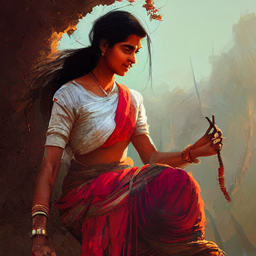

In [13]:
# Then we can generat them like this
gen_with_text_embeddings(text_embeds, seed=233)

## How we can make the Embeddings

Inside the encoder, there's a CLIP based text model.
It has a set of embeddings generater & the trained model as the encoder.

Then we pass these embeddings into the generater to make the final embeddings

In [14]:
# Let's analyze the text_model embeddings
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

In [15]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding

### Token Embeddings

In [16]:
token_info.input_ids.shape

torch.Size([1, 77])

In [17]:
#let's make these embeddings
token_embs = token_emb_layer(token_info.input_ids.to(0))
token_embs.shape

torch.Size([1, 77, 768])

In [18]:
# basically this will add 786 items to each token_id
# we can inspect such an embeddings
token_embs[0][9].shape

torch.Size([768])

In [19]:
# Here it says it has 49408 embeddings.
# That's means our language model knows these amount of words
token_emb_layer

Embedding(49408, 768)

### Positional Embeddings

In [20]:
pos_emb_layer

Embedding(77, 768)

In [21]:
# These are the position ids we haves
pos_ids = text_encoder.text_model.embeddings.position_ids
pos_ids

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76]], device='cuda:0')

Basically, that the index of the each token_id in the array

In [22]:
# Let's get those positional embeddings
pos_embs = pos_emb_layer(pos_ids)
pos_embs.shape

torch.Size([1, 77, 768])

In [23]:
# Just like earlier, we have an embedding for each position
pos_embs[0][9].shape

torch.Size([768])

### Get the Final Embeddings

We can get these final embeddings by sending a these embeddings through a transformer

In [24]:
## First lets merge both token & pos embeddings
merged_embeds = token_embs + pos_embs

In [25]:
# Let's define a function to get transformed embeddings
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True 
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [26]:
get_output_embeds(merged_embeds).shape

torch.Size([1, 77, 768])

0it [00:00, ?it/s]

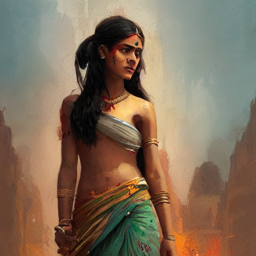

In [27]:
## Let's use these
gen_with_text_embeddings(get_output_embeds(merged_embeds), seed=23)

0it [00:00, ?it/s]

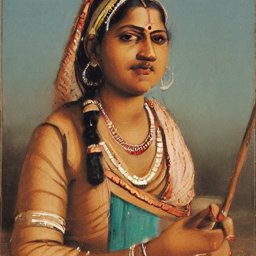

In [28]:
## What happens if we just used token embeddings
gen_with_text_embeddings(get_output_embeds(token_embs), seed=23)

0it [00:00, ?it/s]

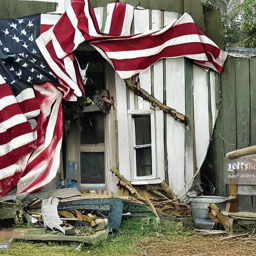

In [29]:
## What happens if we just used only pos embeddings
gen_with_text_embeddings(get_output_embeds(pos_embs), seed=23)

0it [00:00, ?it/s]

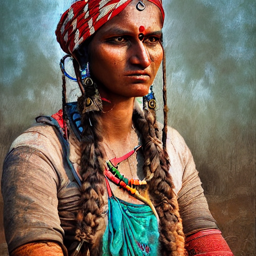

In [30]:
# Here we flip the pos embeddings
# It seems like the meanings of these position reversed. So, the output is different but still meaningful
pos_embs_rev = pos_embs.flip(dims=[0, 1])
gen_with_text_embeddings(get_output_embeds(pos_embs_rev + token_embs), seed=23)

0it [00:00, ?it/s]

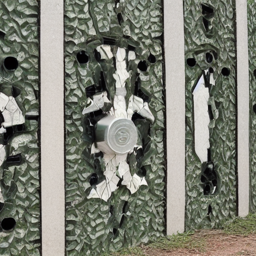

In [31]:
# Here we flip the token embeddings
# Now it will be total BS. Basically it's like we wrote the sentence in the backward
token_embs_rev = token_embs.flip(dims=[0, 1])
gen_with_text_embeddings(get_output_embeds(token_embs_rev + pos_embs), seed=23)

0it [00:00, ?it/s]

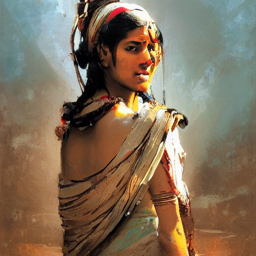

In [32]:
# here we simply add only a portion of pos embeds
gen_with_text_embeddings(get_output_embeds(token_embs + pos_embs * 0.7), seed=23)

## Mixing Text Embeddings

Now we are trying to mix two text embeddings together

In [33]:
import math
def __d(imgs, rows=1, resize_factor=1):
    w,h = imgs[0].size
    cols = math.ceil(len(imgs) / rows)
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid.resize(((int)(grid.size[0] * resize_factor), (int)(grid.size[1] * resize_factor)))

In [34]:
def make_embeddings(prompt):
    token_info = tokenizer(prompt, truncation=True, padding="max_length", return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(token_info.input_ids.to(torch_device))[0]
    return text_embeddings

In [185]:
indian_embs = make_embeddings("a picture of an model indian women with jewelery by greg rutkowski")
other_embs = make_embeddings("a picture of an korean women with by greg rutkowski")

In [188]:
im_indian = gen_with_text_embeddings(indian_embs, seed=23, height=700)

0it [00:00, ?it/s]

In [186]:
im_other = gen_with_text_embeddings(other_embs, seed=23, height=700)

0it [00:00, ?it/s]

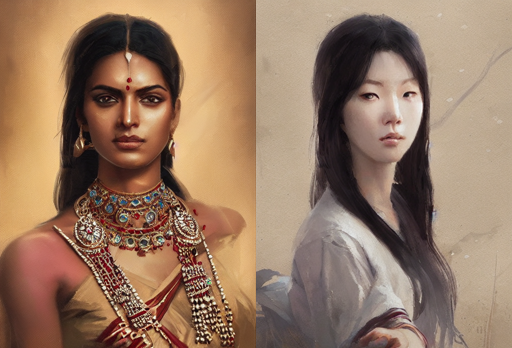

In [189]:
__d([im_indian, im_other])

In [192]:
mix_images = []
for indian_pct in [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.0]:
    other_pct = 1.0 - indian_pct
    im_mix = gen_with_text_embeddings(indian_embs * indian_pct + other_embs * other_pct, seed=23, height=700)
    mix_images.append(im_mix)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

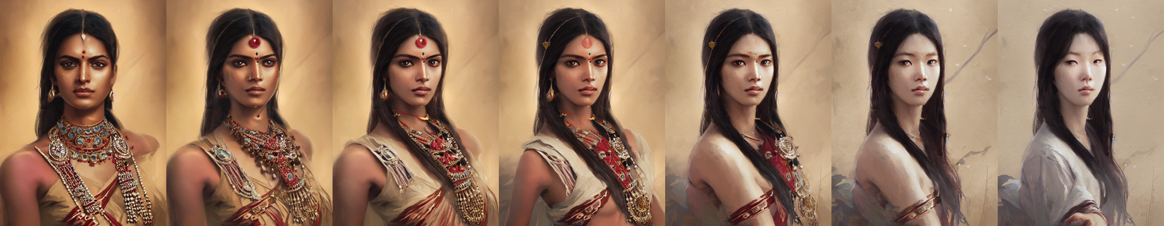

In [193]:
__d(mix_images, resize_factor=0.65)

## Mixing Token Embeddings

Now, we are trying to mix just a single embedding, not the whole.
Here we are mixing both indian & korean together.

In [194]:
tokenizer("indian"), tokenizer("korean")

({'input_ids': [49406, 3606, 49407], 'attention_mask': [1, 1, 1]},
 {'input_ids': [49406, 8034, 49407], 'attention_mask': [1, 1, 1]})

So, here we need to replace the embddings for `3606` & mix that with `3606 & 8034`.

In [195]:
def make_token_embeddings(prompt):
    token_info = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")
    return token_emb_layer(token_info.input_ids.to(torch_device))

In [196]:
base_prompt = "a picture of an model indian women with jewelery by greg rutkowski"

In [197]:
token_embs_indian = make_token_embeddings("indian")[0][1]
token_embs_korean = make_token_embeddings("korean")[0][1]

In [198]:
def find_token_id_by_word(word):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word))[0]

In [199]:
def get_token_index(word):
    return torch.where(tokenizer(base_prompt, padding="max_length", return_tensors="pt").input_ids[0] == find_token_id_by_word(word))[0].item()

In [200]:
base_prompt_token_embs = make_token_embeddings(base_prompt)

0it [00:00, ?it/s]

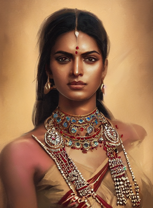

In [201]:
gen_with_text_embeddings(get_output_embeds(base_prompt_token_embs + pos_embs), seed=23, height=700, resize_factor=0.3)

0it [00:00, ?it/s]

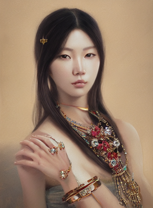

In [202]:
# Let's replace indian with korean
base_prompt_token_embs[0][get_token_index("indian")] = token_embs_korean
gen_with_text_embeddings(get_output_embeds(base_prompt_token_embs + pos_embs), seed=23, height=700, resize_factor=0.3)

In [203]:
# Let's mix them half & half
mix_images = []
for indian_pct in [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.0]:
    korean_pct = 1.0 - indian_pct
    base_prompt_token_embs[0][get_token_index("indian")] = token_embs_indian * indian_pct + token_embs_korean * korean_pct
    im_mix = gen_with_text_embeddings(get_output_embeds(base_prompt_token_embs + pos_embs), seed=23, height=700, resize_factor=0.3)
    mix_images.append(im_mix)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

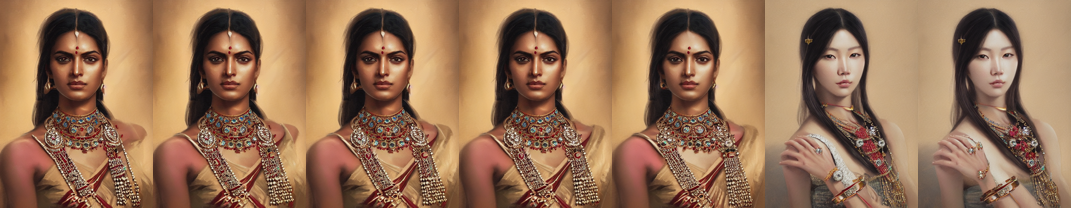

In [204]:
__d(mix_images)

As you can see, it doesn't give us much control.

0it [00:00, ?it/s]

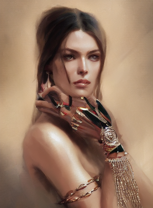

In [205]:
# Let's replace indian with english
token_embs_english = make_token_embeddings("american")[0][1]
base_prompt_token_embs[0][get_token_index("indian")] = token_embs_english
gen_with_text_embeddings(get_output_embeds(base_prompt_token_embs + pos_embs), seed=23, height=700, resize_factor=0.3)

In [206]:
# Let's mix them 
mix_images = []
for indian_pct in [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.0]:
    other_pct = 1.0 - indian_pct
    base_prompt_token_embs[0][get_token_index("indian")] = token_embs_english * other_pct +  token_embs_indian * indian_pct 
    im_mix = gen_with_text_embeddings(get_output_embeds(base_prompt_token_embs + pos_embs), seed=23, height=700, resize_factor=0.3)
    mix_images.append(im_mix)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

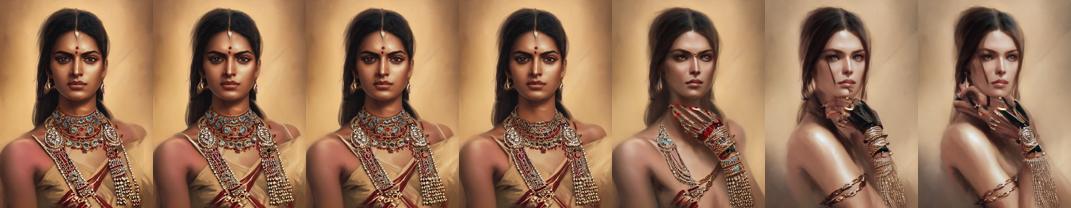

In [207]:
__d(mix_images)

**As you can see, changes are subtle**. But this will defintely has some uses.

## Just Mixing Prompt Words

We can also try mixing these words directly into the prompt.

0it [00:00, ?it/s]

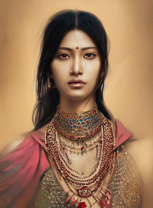

In [208]:
__p = "a picture of an model indian korean women with jewelery by greg rutkowski"
gen_with_text_embeddings(make_embeddings(__p), seed=23, height=700, resize_factor=0.3)

0it [00:00, ?it/s]

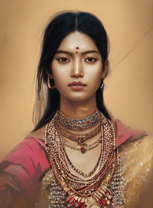

In [209]:
# Let's swap korean & indian
__p = "a picture of an model korean indian women with jewelery by greg rutkowski"
gen_with_text_embeddings(make_embeddings(__p), seed=23, height=700, resize_factor=0.3)

There is a change here, that's because of the position embeddings.